In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 픽셀 값을 0~1 사이로 정규화합니다.
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

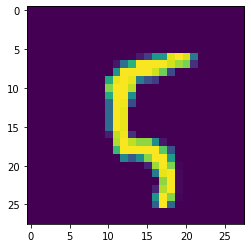

In [ ]:
plt.imshow(x_train[100])

1. 데이터 로딩 
2. 하이퍼파라미터 설정하기 
3. 신경망 & 출력층 설계 및 구현
  * 2층 짜리 신경망
4. 미니배치 구성 & 학습
5. 기울기 (gradient) 계산
6. 가중치 업데이트 
7. 학습 경과 기록하기 (loss function)


In [ ]:
x_train_flatten = x_train.reshape([x_train.shape[0], -1]) 
x_test_flatten = x_test.reshape([x_test.shape[0], -1]) 

In [ ]:
# t_train.shape

(60000,)

In [ ]:
# 하이퍼파라미터 설정 
iters_num = 10000 # 반복 횟수
train_size = x_train_flatten. shape[0] # 28x28 -> 784로 flatten
batch_size = 100 # 미니배치 크기 
learning_rate = 0.1 # 학습률 

In [ ]:
def softmax(a):
  ## a 배열 각 요소에 exp 실행 
  exp_a = np.exp(a)
  ## 분모에 들어갈 합 계산 
  sum_exp_a = np.sum(exp_a)
  ## 각 요소를 합으로 나눠줌 
  y = exp_a / sum_exp_a

  return y

def sigmoid(x):
  return 1 / (1 + np.exp(-x)) 

In [ ]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size) 
  
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size 

In [ ]:
def predict(network, x):
  W1, W2 = network['W1'], network['W2']
  b1, b2 = network['b1'], network['b2']

  # 입력층 -> 은닉층 (1층)
  a1 = np.dot(x, W1) + b1
  z1 = sigmoid(a1)

  # 1층 -> 2층 
  a2 = np.dot(z1, W2) + b2 
  # MNIST data를 분류하는 문제니까.. 
  # 마지막 layer의 활성화 함수는 => softmax
  y = softmax(a2) 

  return y

In [ ]:
import numpy as np

In [ ]:
def numerical_gradient(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x) 

  for idx in range(x.shape[0]):
    tmp_val = x[idx]

    # y증가량 / x증가량 = 기울기 
    # y증가량 : f(x+h) - f(x-h)
    # f(x+h) 
    x[idx] = tmp_val + h 
    fxh1 = f(x)

    # f(x-h)
    x[idx] = tmp_val - h
    fxh2 = f(x)

    # gradient 값 저장 
    grad[idx] = (fxh1 - fxh2) / (2*h)

    x[idx] = tmp_val

  return grad

## 2층 신경망 class 정의 

In [ ]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 가중치 초기화 
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1 
    z1 = sigmoid(a1)

    a2 = np.dot(z1, W2) + b2 
    y = softmax(a2)

    return y 

  # 손실 함수 값 x : 입력 데이터, t : 정답 데이터 
  def loss(self, x, t):
    y = self.predict(x)
    loss = cross_entropy_error(y, t)
    return loss

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y==t) / float(x.shape[0])

    return accuracy 

  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    
    return grads 

In [ ]:
# 하이퍼파라미터 설정 
iters_num = 10000 # 반복 횟수
train_size = x_train_flatten.shape[0] # 28x28 -> 784로 flatten
batch_size = 100 # 미니배치 크기 
learning_rate = 0.01 # 학습률 

# 네트워크 
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

train_loss_list = []

for i in range(iters_num):
  # 학습할때는 'batch_size' 만큼씩 뽑아서 사용 
  batch_mask = np.random.choice(train_size, batch_size)
  # batch input
  x_batch = x_train_flatten[batch_mask]
  # 정답 label
  t_batch = t_train[batch_mask]
  
  # 기울기 (gradient) 계산
  grad = network.numerical_gradient(x_batch, t_batch)

  # 가중치 업데이트
  for key in ('W1', 'W2', 'b1', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  # 학습 경과 기록하기 (loss function)
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)
  print(loss)